In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

import sys
sys.path.insert(1, '../library')
import pyram as pr

from sklearn.linear_model import LinearRegression
import scipy
from itertools import combinations

from scipy.spatial import distance

%matplotlib inline

Welcome to pyram: your Raman analysis library!


In [2]:
pr.charge_lib('full')

Charging pure spectra library, needs around a minute ....
Done. Good work!


In [3]:
lib = pr.lib()
lib_names = list(lib.keys())

In [4]:
pr.cwd('example_data')
pr.set_alias()

txt0  ->  Sample01_A_10x6s_633nm_G1200_F100__Ox100LWD.txt
txt1  ->  Sample01_B_10x30s_633nm_G1200_F1__Ox100LWD.txt
txt2  ->  Sample01_C_10x20s_633nm_G1200_F10__Ox100LWD.txt
txt3  ->  Sample01_D_6x4s_633nm_G1200_F100__Ox10.txt
txt4  ->  Sample01_E_6x4s_633nm_G1200_F100__Ox100LWD.txt
txt5  ->  Sample01_F_10x5s_633nm_G1200_F0_1__Ox100LWD.txt
txt6  ->  Sample01_G_6x10s_633nm_G1200_F10__Ox100LWD.txt
txt7  ->  Sample01_H_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt8  ->  Sample01_I_10x10s_633nm_G1200_F25__Ox100LWD.txt
txt9  ->  Sample01_J_10x5s_633nm_G1200_F10__Ox100LWD.txt
txt10  ->  Sample01_K_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt11  ->  Si_calibration_A_60x1s_633nmnm_G1200_F100__Ox100.txt


sum(Y-XW) =  -4304089.38392287
message =  Optimization terminated successfully.
# of iter =  360


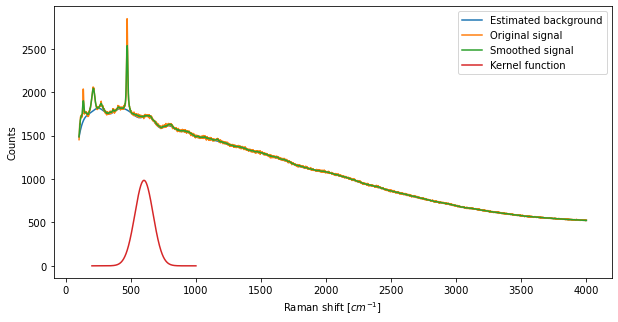

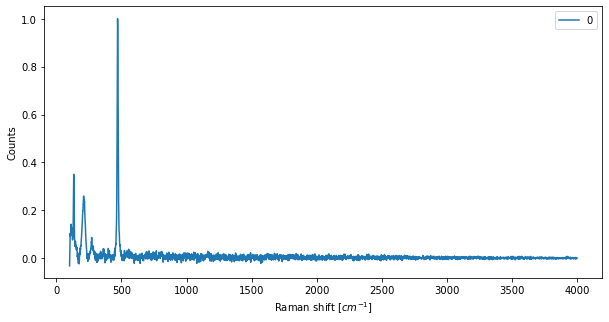

In [5]:
S=pr.type2spectra('txt10')
S=pr.bkg_subtraction(S,sigma=70, L_n=11,plot=True)
pr.plot(S)

  alias                         name     match
0  sch0  Quartz__X080015__Raman__780  0.970411
1  sch1  Quartz__X080016__Raman__780  0.960419
2  sch2  Quartz__X080016__Raman__532  0.951638
3  sch3  Quartz__X080015__Raman__532  0.948960
4  sch4  Quartz__R060604__Raman__532  0.942205
5  sch5  Quartz__R060604__Raman__780  0.942074
6  sch6  Quartz__R040031__Raman__514  0.940152
7  sch7  Quartz__R050125__Raman__780  0.939168
8  sch8  Quartz__R040031__Raman__780  0.935910
9  sch9  Quartz__R050125__Raman__532  0.934386


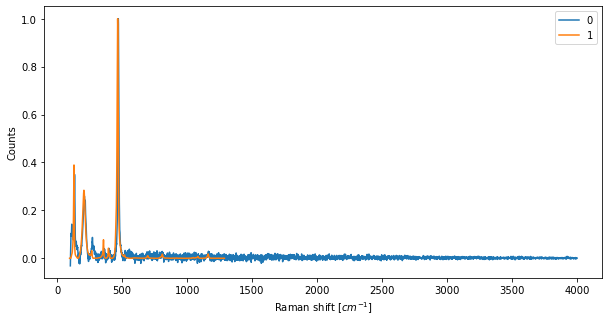

In [18]:
A = pr.search(S,shift=5)
pr.plot([S,'sch0'])

# 2D similarity - basic implementation => needs small library

In [8]:
pr.charge_lib('short')


shift=5
per = 0.1

lib=pr.lib()
lib_names=list(lib.keys())

match = []
names = []
step = np.linspace(0,1,5)
step = step[1:-1]
for a in range(len(lib_names)):
    for b in range(len(lib_names)):
        if b>a:
            
            N = 2
            A=pr.lib(lib_names[a]).copy()
            A[1] /=  np.max(A[1])
            B=pr.lib(lib_names[b]).copy()
            B[1] /=  np.max(B[1])
            min = np.max([A[0,0],B[0,0]])
            max = np.min([A[0,-1],B[0,-1]])
            min_A = np.where(A[0]==min)[0][0]
            max_A = np.where(A[0]==max)[0][0]
            min_B = np.where(B[0]==min)[0][0]
            max_B = np.where(B[0]==max)[0][0]
            A = A[:,min_A:max_A]
            B = B[:,min_B:max_B]

            temp=[0,0]
            for i in step:
                X = np.array([A[0,:], i*A[1,:]+(1-i)*B[1,:]])
                t = pr.cos_sim_w_shift(S,X ,shift)
                if t>temp[1]:
                    temp[1] = t
                    temp[0] = str(i)+' '+lib_names[a]+', '+str(1-i)+' '+lib_names[b]
                
            
            x1 = pr.cos_sim_w_shift(S, pr.lib(lib_names[a]),shift) # da modificare il modo
            x2 = pr.cos_sim_w_shift(S, pr.lib(lib_names[b]),shift)
            if (temp[1]>np.max([x1,x2])*(1+per)): 
                names.append(temp[0])
                match.append(temp[1])
        
        if b==a:
            B = pr.lib(lib_names[a]).copy()
            names.append(lib_names[a])
            match.append(pr.cos_sim_w_shift(S,B,shift))
            

match = pd.DataFrame({'spectra':names, 'match':match})    
match.sort_values('match', ascending=False, inplace=True)
match.reset_index(inplace=True, drop=True)
print(match.head(10))

Charging pure spectra library, needs around a minute ....
Done. Good work!
                               spectra     match
0                               Quartz  0.906081
1           0.5 Pimelite, 0.5 Titanite  0.445652
2                               Albite  0.441882
3     0.5 Chalcopyrite, 0.5 Phlogopite  0.436579
4       0.5 Chalcopyrite, 0.5 Pimelite  0.436321
5         0.5 Phlogopite, 0.5 Titanite  0.425423
6     0.75 Chalcopyrite, 0.25 Titanite  0.421244
7         0.5 Microcline, 0.5 Titanite  0.398882
8         0.5 Orthoclase, 0.5 Titanite  0.394084
9  0.75 Chalcopyrite, 0.25 Clinochlore  0.390775


# 2D search: looking for a smarter implementation

In [384]:
########### WORKING WITH ##############
shift = 5
S
#pr.charge_lib('full')

array([[ 1.01000000e+02,  1.02000000e+02,  1.03000000e+02, ...,
         3.99700000e+03,  3.99800000e+03,  3.99900000e+03],
       [-3.31447021e+01,  3.33781576e-01,  3.57008590e+01, ...,
        -1.70807232e+00,  2.11340289e+00,  1.98203822e+00]])

In [385]:
pr.charge_lib('full')

Charging pure spectra library, needs around a minute ....


KeyboardInterrupt: 

In [ ]:
lib=pr.lib()
lib_names=list(lib.keys())

###################################################################################
########### PUTTING THE LIBRARY IN AN NP.ARRAY with the computed shifts ###########
###################################################################################

# the nan values are padded with zeros!
m = len(lib_names)

# searching the minimum and the maximum wn of the library (to get the # of columns)
min = lib[lib_names[0]][0].min()
max = lib[lib_names[0]][0].max()

for el in lib_names[1:]:
    min_t = lib[el][0].min()
    max_t = lib[el][0].max()

    if min_t<min:
        min = min_t
    if max_t>max:
        max = max_t

wn = np.arange(min-shift,max+1+shift,1)
n = len(wn+2*shift)

# rewriting the library in a np.array
LIB = np.zeros((m,n))

for i in range(len(lib_names)):
    min_t = lib[lib_names[i]][0].min()
    max_t = lib[lib_names[i]][0].max()
    
    # computing the shift
    match = 0
    for s in np.arange(-shift,shift+1):
        B_temp = lib[lib_names[i]].copy()
        B_temp[0] += s

        match_new = pr.cos_sim(S,B_temp)                                       #################
        if match_new>match:
            match = match_new
            out = s

    #adding the shifted spectra to the library
    LIB[i][int(min_t-min+shift)+out:n-int(max-max_t+shift)+out]  = lib[lib_names[i]][1]

# rescaling the height to 1
LIB = (LIB.transpose()/LIB.max(axis=1)).transpose()

In [ ]:
###############################################################################################
############# CHANGING LIBRARY OF THE SPECTRA, SPECIFYING FOR THE S WE ARE FACING #############
###############################################################################################

############################################
set_min = 200
set_max = 1500
############################################

# here we prepare common wn between S and the library

# ausiliar variables
S_work = copy.deepcopy(S)
S_work[1] = S_work[1]/S_work[1].max()

# changing dimensions of LIB_temp or S_work
min_1 = np.min(S_work[0])
min_2 = np.min(wn)
max_1 = np.max(S_work[0])
max_2 = np.max(wn)

if set_min==None: #i.e se non è settato un minimo settalo come quello comune
    min = np.max([min_1,min_2])
else:
    min = set_min
if set_max==None: #i.e se non è settato un massimo settalo come quello comune
    max = np.min([max_1,max_2])
else:
    max = set_max

if min_1<min:
    S_work = S_work[:,int(min-min_1):]
if min_2<min:
    wn = wn[int(min-min_2):]
    LIB = LIB[:,int(min-min_2):]
if max_1>max:
    S_work = S_work[:,:int(max-max_1)]
if max_2>max:
    wn = wn[:int(max-max_2)]
    LIB = LIB[:,:int(max-max_2)]

In [ ]:
#############################################################################################
############# LINEAR REGRESSION FOR THE SEARCH OF USEFUL SPECTRA IN THE LIBRARY #############
#############################################################################################
 
#################################
th = 0.01 # trashold on the linear regression coefficients
bin=5    # binning for the linear regression speedup
#################################

# binning for the speed up of the linear regression
LIB_temp = LIB[:,:(LIB.shape[1] // bin)*bin].reshape(LIB.shape[0],LIB.shape[1]//bin,bin).mean(axis=2)
wn_temp = wn[:(wn.shape[0] // bin)*bin].reshape(wn.shape[0]//bin,bin).mean(axis=1)
S_temp = S_work[:,:(S_work.shape[1] // bin)*bin].reshape(S_work.shape[0],S_work.shape[1]//bin,bin).mean(axis=2)

# linear regression
reg = LinearRegression(fit_intercept=False, positive=True)
reg.fit(LIB_temp.transpose(),S_temp[1])

# plot the regression
plt.figure(figsize=(10,5))
plt.plot(wn_temp,np.dot(LIB_temp.transpose(),reg.coef_))
plt.plot(S_temp[0],S_temp[1])
plt.show()

# number of used spectrums, selection of rely used spectra
lib_used = []
for i in range(len(reg.coef_)):
    if reg.coef_[i]>th:
        lib_used.append(i)

print('################################################################')
print('# of used spectra = ',len(lib_used))

# selected spectra sumup
sumup = []
for i in range(len(lib_used)):
    sumup.append([lib_used[i],lib_names[lib_used[i]] , reg.coef_[lib_used[i]]])

sumup = pd.DataFrame(sumup, columns=['ID','name','regression coefficient'])
print(sumup)

################################################################
# of used spectra =  11
      ID                                   name  regression coefficient
0    862           Calomel__R070370__Raman__785                0.175397
1   1249         Covellite__R060129__Raman__532                0.011612
2   1800  Fluorophlogopite__R040039__Raman__532                0.011266
3   2536         Karpatite__R060162__Raman__785                0.026733
4   3103        Moissanite__R061083__Raman__532                0.011873
5   3758            Quartz__X080015__Raman__780                0.704657
6   3760            Quartz__X080016__Raman__780                0.101604
7   4023       Scotlandite__R060764__Raman__785                0.046622
8   4148          Sodalite__R040141__Raman__514                0.010065
9   4352           Sulphur__R040135__Raman__532                0.035423
10  4463      Terlinguaite__R060492__Raman__785                0.038610


In [ ]:
#########################################################################################
############# GENERATION OF THE REQUIRED SPECTRA IN THE RIGHT CONFIGURATION #############
#########################################################################################

# generation of the required pure spectra (also shifted)
pure = np.take(LIB,list(sumup.ID),axis=0)
pure.shape

(11, 1301)

In [429]:
def ND_cos_sim(S,X):

    if X.shape[0]>1:
        # riempio la matrice X
        X = X.transpose()

        # calcolo la trasposta
        Xt = X.transpose()

        # calcolo la proiezione
        w = np.linalg.multi_dot([X ,np.linalg.inv( np.dot(Xt,X) ), Xt, S[1]])

        # e infine la cosine similarity
        match = 1-distance.cosine(w,S[1])

    if X.shape[0]==1:
        match = 1-distance.cosine(LIB[el],S[1])

    return match

In [437]:
#############################################################
############# FINAL FIT USING COSINE SIMILARITY #############
#############################################################

N = 2


# genero le N combinazioni tra i pure spectra selezionati
comb = list(combinations(list(sumup.index),N))

print('trying N =', N,'; resulting in', len(comb), 'combinations')

# and finaly let's compute the similarity for each combination
results = [0]*len(comb)

for c in enumerate(comb):
    
    if N>1:
        # minimization of the problem
        X = pure.take(c[1],axis=0)

        # store results
        # combination, similarity
        results[c[0]] = [c[1], ND_cos_sim(S_work,X) ]
    
    if N==1:
        tot = pure[c[1][0]]
        results[c[0]] = [c[1], np.dot(S_work[1],tot) / np.sqrt(np.dot(S_work[1],S_work[1])*np.dot(tot,tot)) ]

# decode results

for i in range(len(results)):
    temp = [0]*N
    for j in range(N):
        temp[j]= sumup.name[results[i][0][j]]

    results[i][0] = temp

results = pd.DataFrame(results, columns=['combination','similarity'])


results.sort_values(by=['similarity'], inplace=True, ascending=False)
results.reset_index(inplace=True,drop=True)

display(results.head())

trying N = 2 ; resulting in 55 combinations


,combination,similarity
0,"[Calomel__R070370__Raman__785, Quartz__X080015...",0.983122
1,"[Quartz__X080015__Raman__780, Terlinguaite__R0...",0.982361
2,"[Quartz__X080015__Raman__780, Sodalite__R04014...",0.981433
3,"[Quartz__X080016__Raman__780, Terlinguaite__R0...",0.981355
4,"[Quartz__X080015__Raman__780, Scotlandite__R06...",0.981328


## Some test

In [ ]:
S=pr.type2spectra('txt11')
S[1]=S[1]+10*S[0]
S=pr.bkg_subtraction(S,sigma=70,plot=True, L_n=11)
pr.plot(S)
pr.NDsearch(S,10);